In [117]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import *
from keras.optimizers.legacy import Adam, RMSprop
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.preprocessing import MinMaxScaler

sns.set_theme(rc={'figure.figsize':(16,8)})

def count_compare_plot(df, column, compare_column, stat="count", rotation=0, order=None):
    plt.figure(figsize=(12,6))
    sns.countplot(df, x=df[column], hue = df[compare_column], palette='Greens_r', gap=0.05, 
                  stat=stat, order=order)
    plt.xticks(rotation=rotation)
    plt.legend()
    plt.show()


def hist_compare_plot(df, column, compare_column):
    for x in [0,1]:
        df[column][df[compare_column]==x].plot(kind='kde')
        
    plt.title(f'{compare_column} vs {column} Density Distribution')
    plt.legend(('0','1'))
    plt.xlabel(column)
    plt.show()

In [118]:
df = pd.read_csv("heart.csv")
df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1020,59,1,1,140,221,0,1,164,1,0.0,2,0,2,1
1021,60,1,0,125,258,0,0,141,1,2.8,1,1,3,0
1022,47,1,0,110,275,0,0,118,1,1.0,1,1,2,0
1023,50,0,0,110,254,0,0,159,0,0.0,2,0,2,1


* age: age in years
* sex: sex (1 = male; 0 = female)
* cp: chest pain type
        -- Value 1: typical angina
        -- Value 2: atypical angina
        -- Value 3: non-anginal pain
        -- Value 4: asymptomatic
* trestbps: resting blood pressure (in mm Hg on admission to the hospital)
* chol: serum cholestoral in mg/dl
* fbs: (fasting blood sugar > 120 mg/dl)  (1 = true; 0 = false)
* restecg: resting electrocardiographic results
        -- Value 0: normal
        -- Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
        -- Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina (1 = yes; 0 = no)
* oldpeak = ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
        -- Value 1: upsloping
        -- Value 2: flat
        -- Value 3: downsloping
* ca: number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect


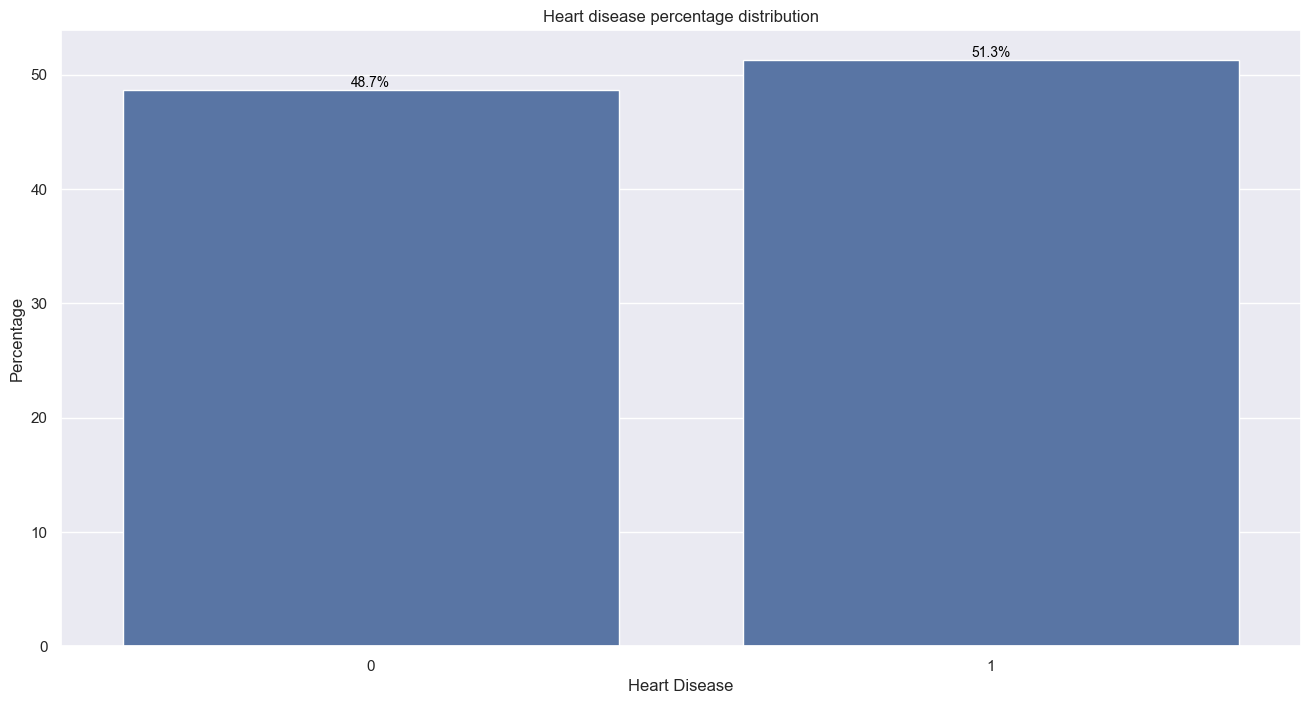

In [119]:
ax = sns.countplot(data=df, x="target", stat="percent")
plt.ylabel("Percentage")
plt.xlabel("Heart Disease")
plt.title("Heart disease percentage distribution")


for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

<Axes: >

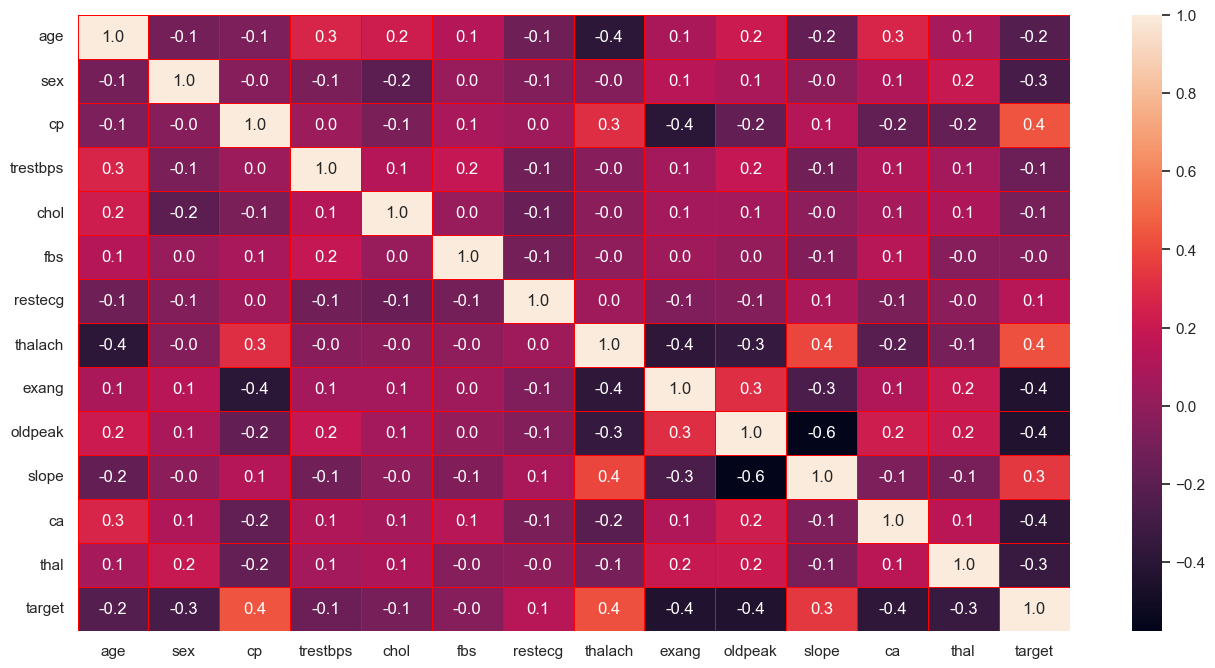

In [120]:
sns.heatmap(df.corr(), annot=True, linewidths=0.5, linecolor="red", fmt= '.1f')

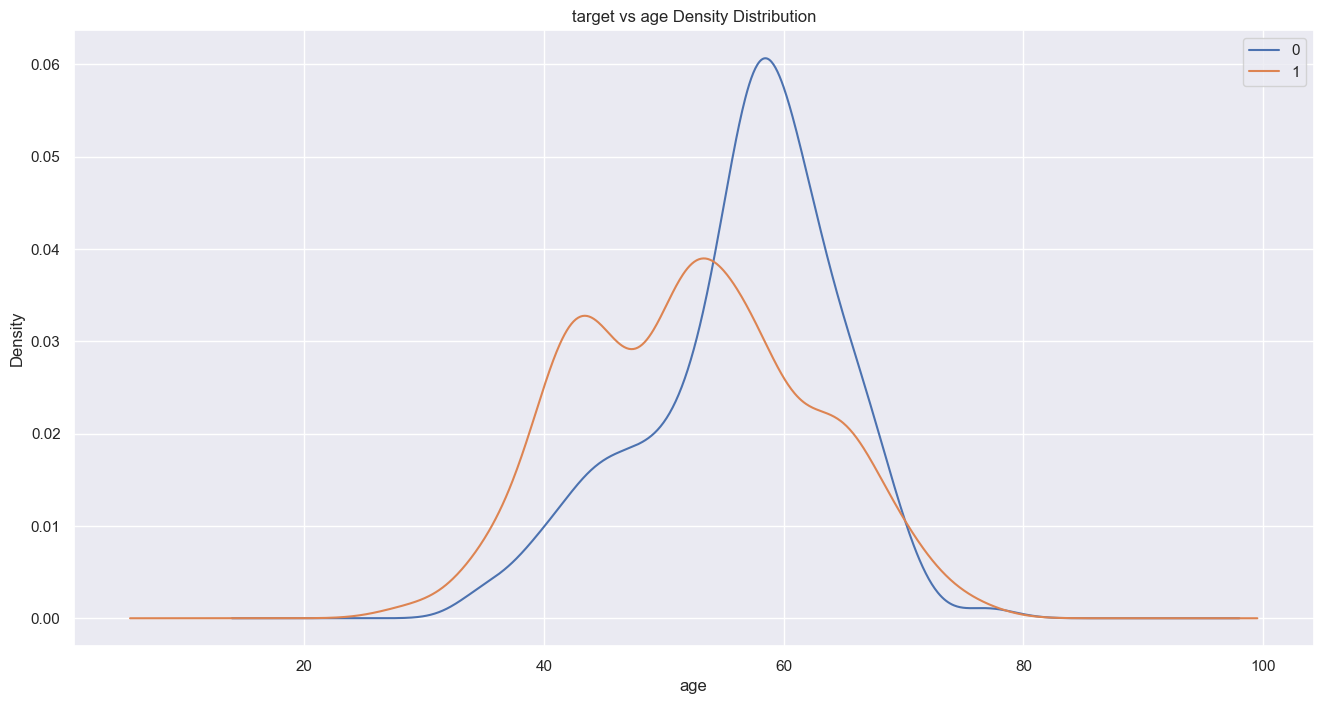

In [121]:
hist_compare_plot(df, "age", "target")

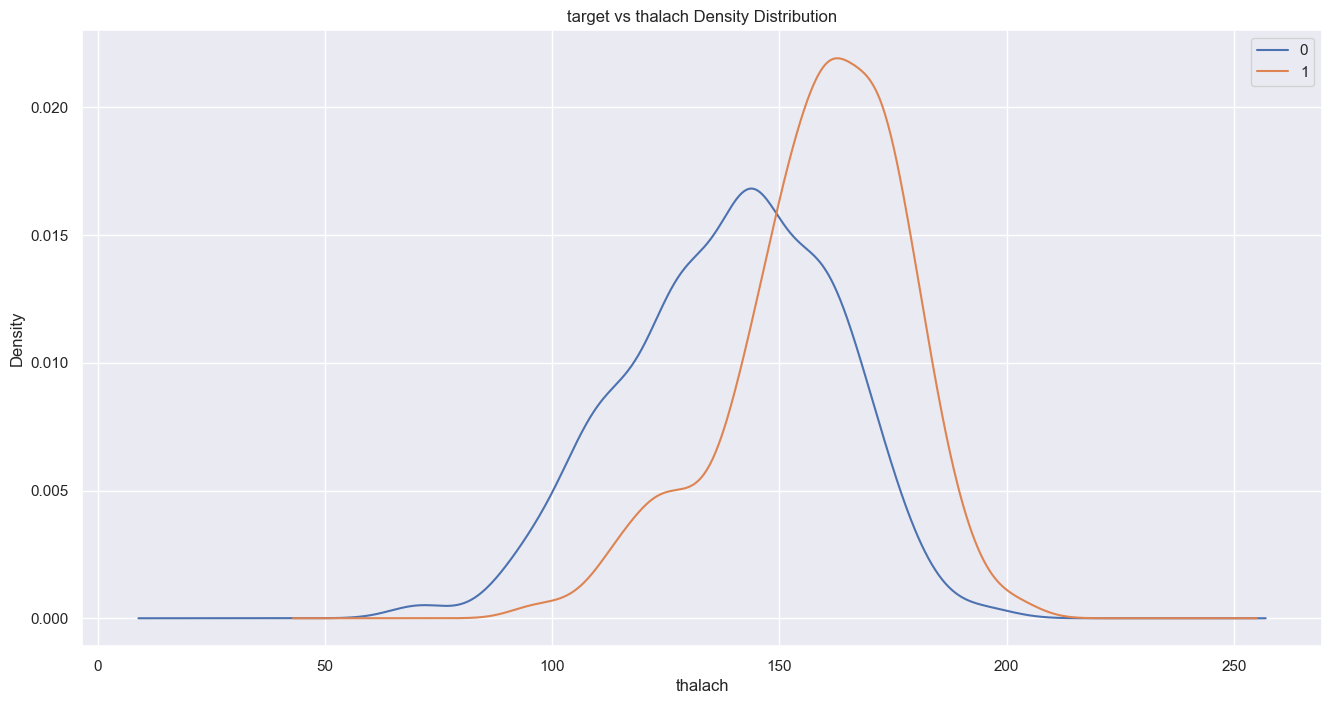

In [122]:
hist_compare_plot(df, "thalach", "target")

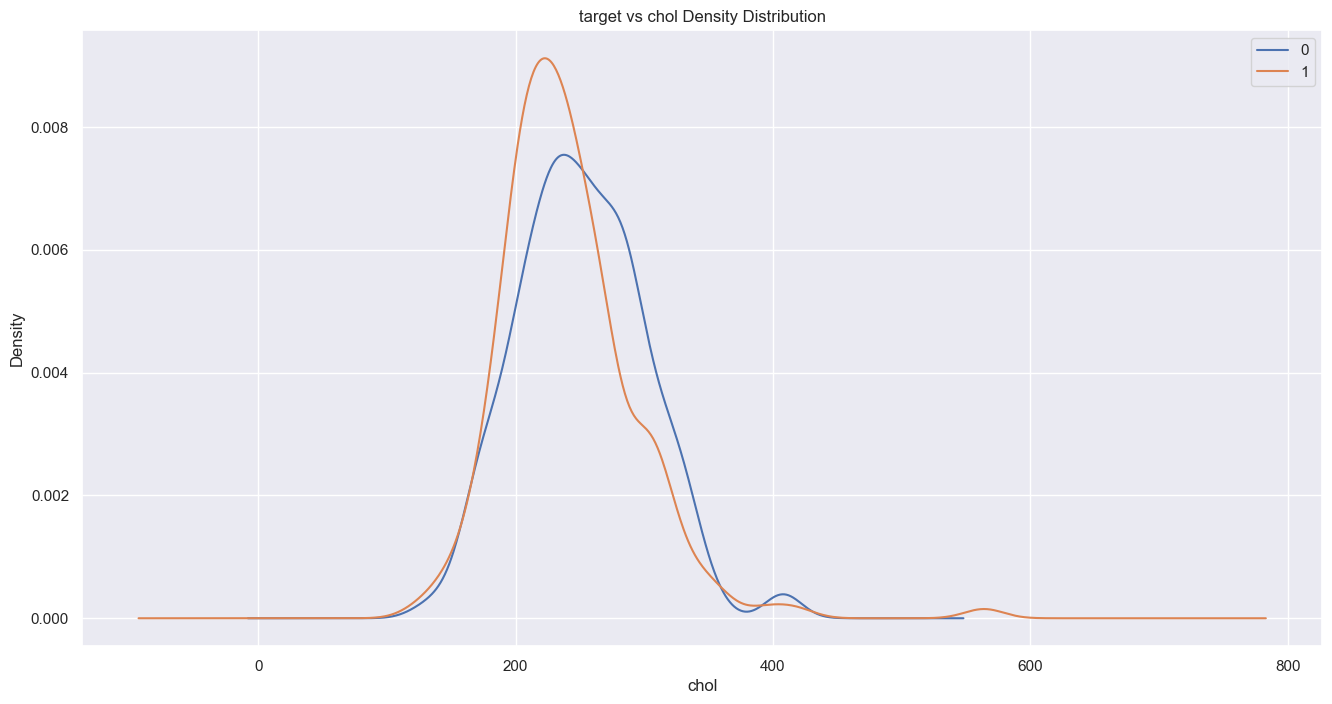

In [123]:
hist_compare_plot(df, "chol", "target")

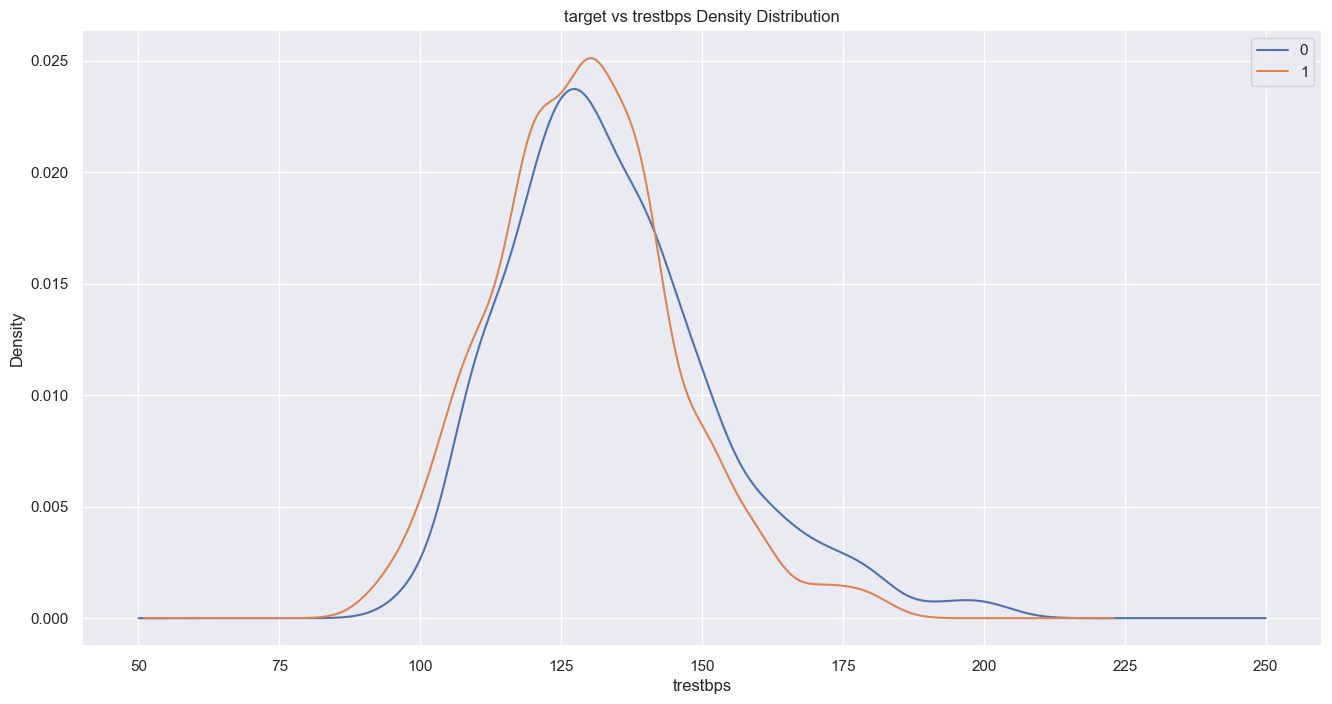

In [124]:
hist_compare_plot(df, "trestbps", "target")

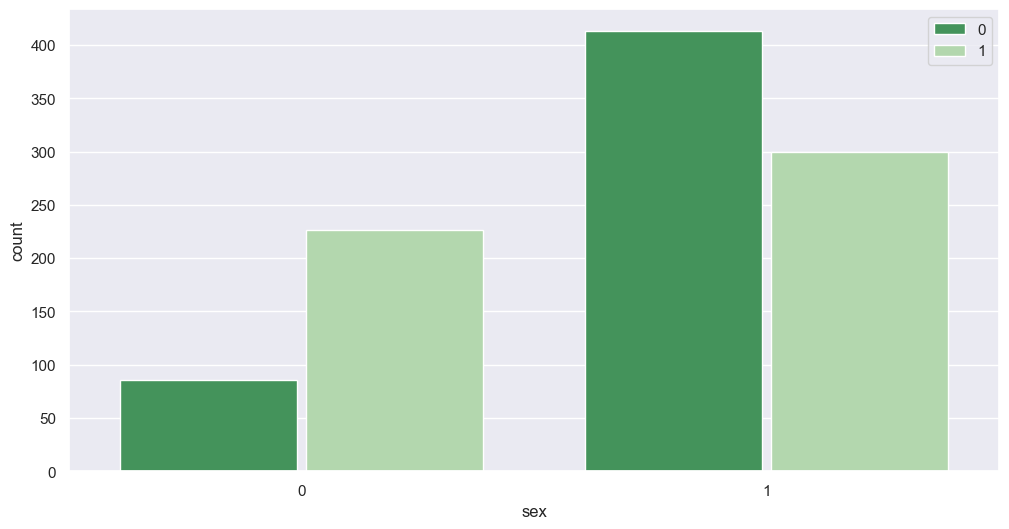

In [125]:
count_compare_plot(df, "sex", "target")
# 1 male, 0 female on x axis

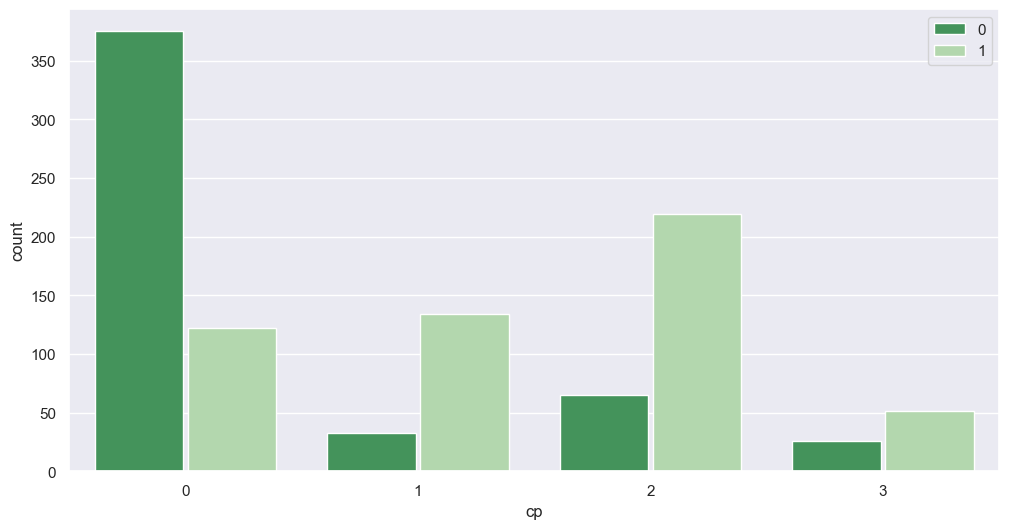

In [126]:
count_compare_plot(df, "cp", "target")
#-- Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic

In [127]:
def main(model_name, df=df, epochs=200, batch_size=30, optimizer=Adam(), activation_function="relu",
         neurons=[1,64,32,16], extra_layers=False, scale=True):
    
    Y = df.iloc[:,-1]
    X = df.iloc[:,:-1]

    if scale:
        scaler = MinMaxScaler()
        scaler.fit(X)
        X = pd.DataFrame(scaler.fit_transform(X))
    
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=45)
    #X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.10, shuffle=True, random_state=45)

    # Build
    model = Sequential()
    model.add(Dense(neurons[1], activation_function, input_shape=(13,)))
    if extra_layers: 
        model.add(Dense(neurons[2], activation_function))
        model.add(Dense(neurons[3], activation_function))
    model.add(Dense(neurons[0], 'sigmoid'))  

    # Compile 
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer=optimizer)
    model.summary()

    # Fit 
    model_fit = model.fit(X_train, Y_train, validation_split=0.15, batch_size=batch_size, epochs=epochs, verbose=True)    

    predicted = model.predict(X_test)

    # Get accuracy
    train_accuracy = model_fit.history['accuracy']
    val_accuracy = model_fit.history['val_accuracy']

    # Plot accuracy
    epochs = range(1, len(train_accuracy) + 1)
    plt.ylim(0,1)
    plt.plot(epochs, train_accuracy, label=f'{model_name} training')
    plt.plot(epochs, val_accuracy, label=f'{model_name} validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    return (Y_test, predicted)



def plot_confusion_matrix(Y_test, predicted):
    predicted = tf.squeeze(predicted)
    predicted = np.array([1 if x >= 0.5 else 0 for x in predicted])
    actual = np.array(Y_test)
    conf_mat = confusion_matrix(actual, predicted)
    displ = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    displ.plot()

## Scale

Model: "sequential_82"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_190 (Dense)           (None, 64)                896       
                                                                 
 dense_191 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
24/24 [==============================] - 1s 10ms/step - loss: 0.7089 - accuracy: 0.5022 - val_loss: 0.6621 - val_accuracy: 0.6911
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6280 - accuracy: 0.7719 - val_loss: 0.6023 - val_accuracy: 0.7967
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5607 - accuracy: 0.8221 - val_loss: 0.5503 - val_accuracy: 0.7805
Epoch 4/200
24/24 [==============================] - 0s 3ms/step - loss: 0.5016 - accuracy: 0.8207 - val_loss: 0.5038 - val_accuracy: 0.7805
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4553 - accuracy: 0.8250 - val_loss: 0.4730 - val_accuracy: 0.8049
Epoch 6/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4238 - accuracy: 0.8221 - val_loss: 0.4529 - val_accuracy: 0.7805
Epoch 7/200
24/24 [==============================] - 0s 3ms/step - loss: 0.4017 - accuracy: 0.8350 - val_loss: 0.4390 - val_accuracy: 0.8130
Epoch 8/200


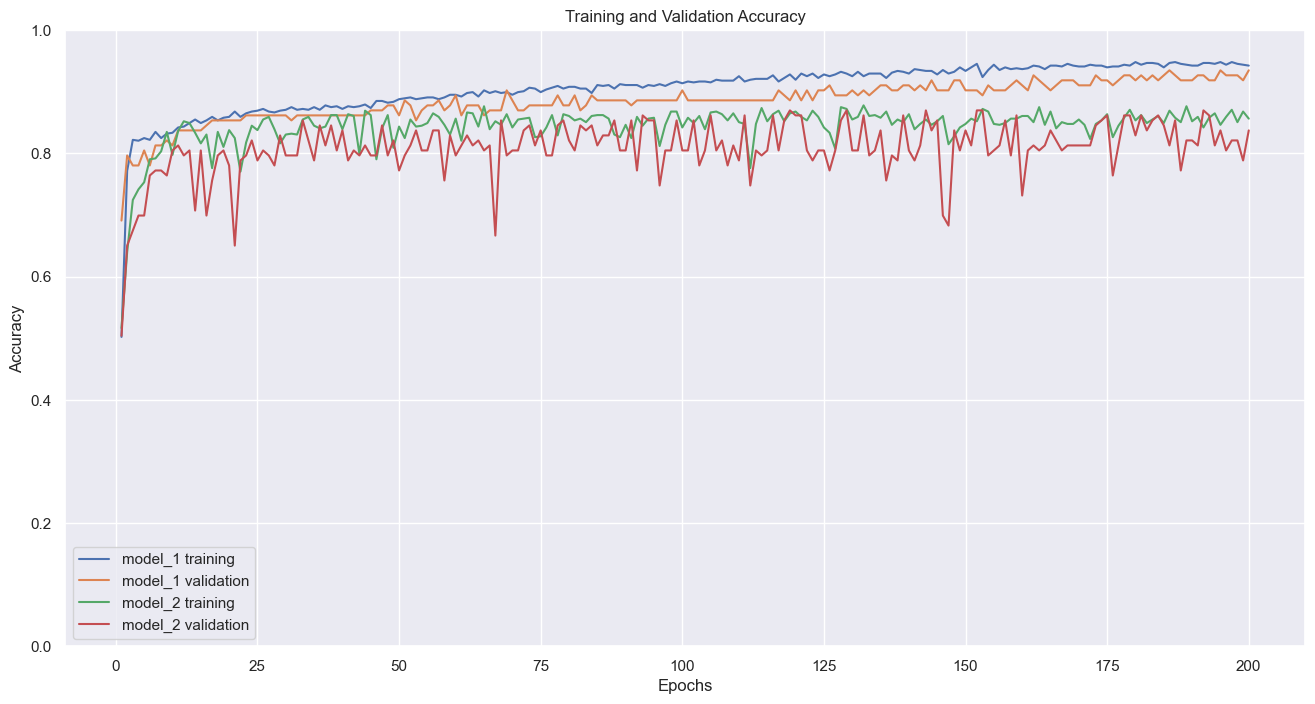

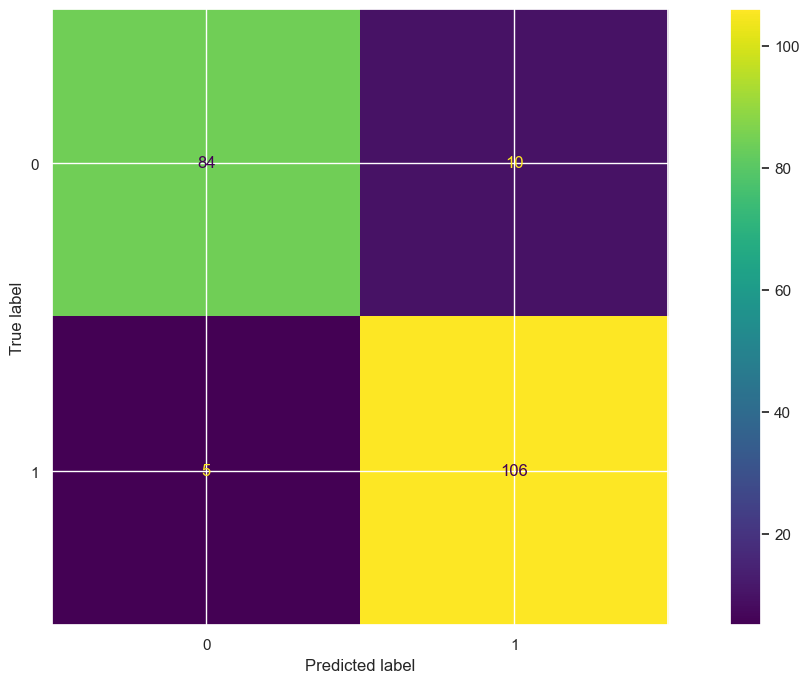

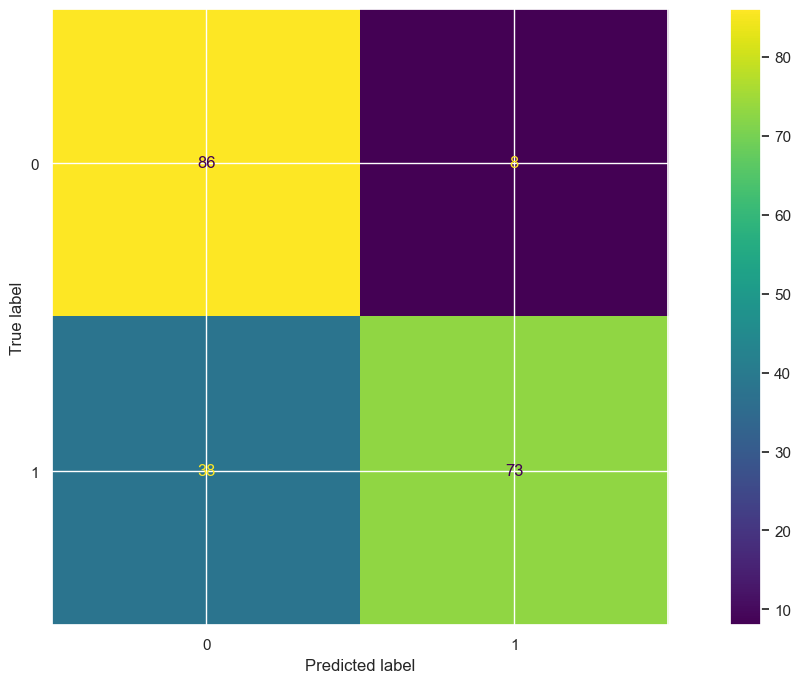

In [128]:
Y_test, predicted1 = main("model_1", scale=True)
Y_test, predicted2 = main("model_2", scale=False)

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Optimizer

Model: "sequential_84"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_194 (Dense)           (None, 64)                896       
                                                                 
 dense_195 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
24/24 [==============================] - 0s 7ms/step - loss: 0.6851 - accuracy: 0.5854 - val_loss: 0.6471 - val_accuracy: 0.7886
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.6108 - accuracy: 0.8121 - val_loss: 0.5901 - val_accuracy: 0.8130
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5492 - accuracy: 0.8350 - val_loss: 0.5415 - val_accuracy: 0.8211
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4977 - accuracy: 0.8250 - val_loss: 0.5013 - val_accuracy: 0.8049
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4557 - accuracy: 0.8221 - val_loss: 0.4717 - val_accuracy: 0.8130
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4243 - accuracy: 0.8321 - val_loss: 0.4511 - val_accuracy: 0.8130
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8350 - val_loss: 0.4362 - val_accuracy: 0.8130
Epoch 8/200
2

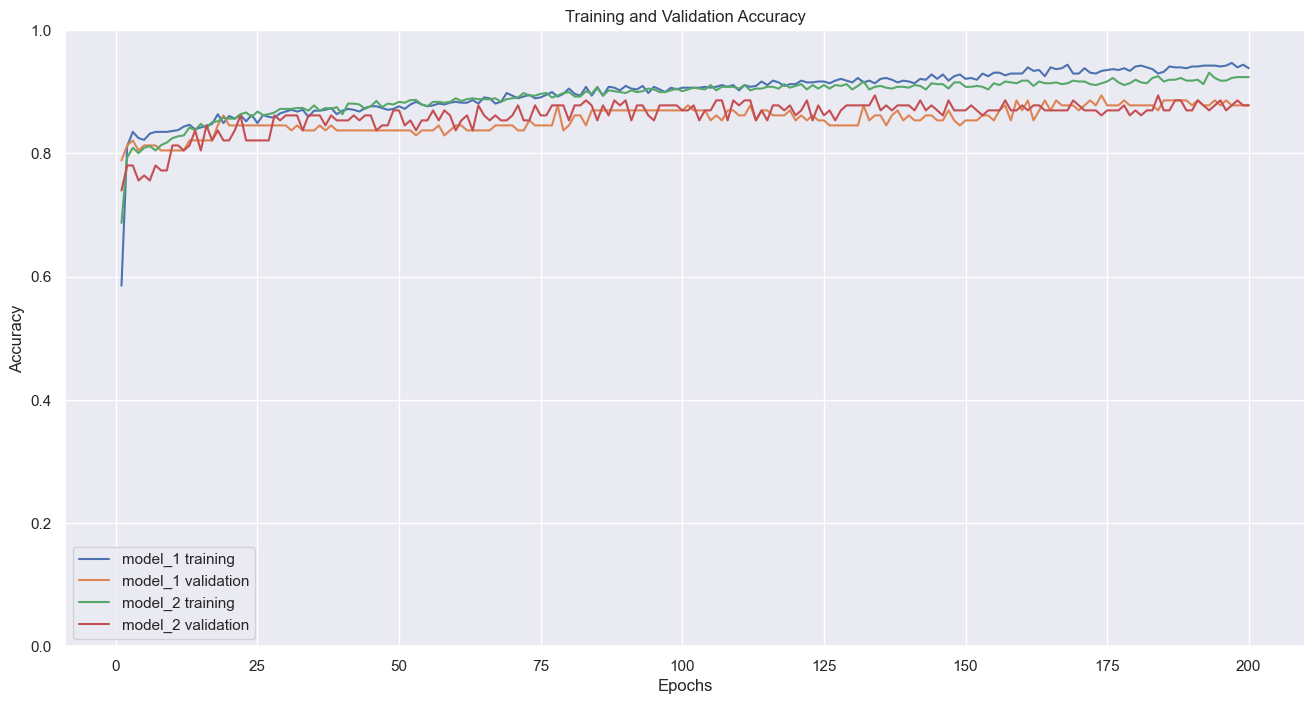

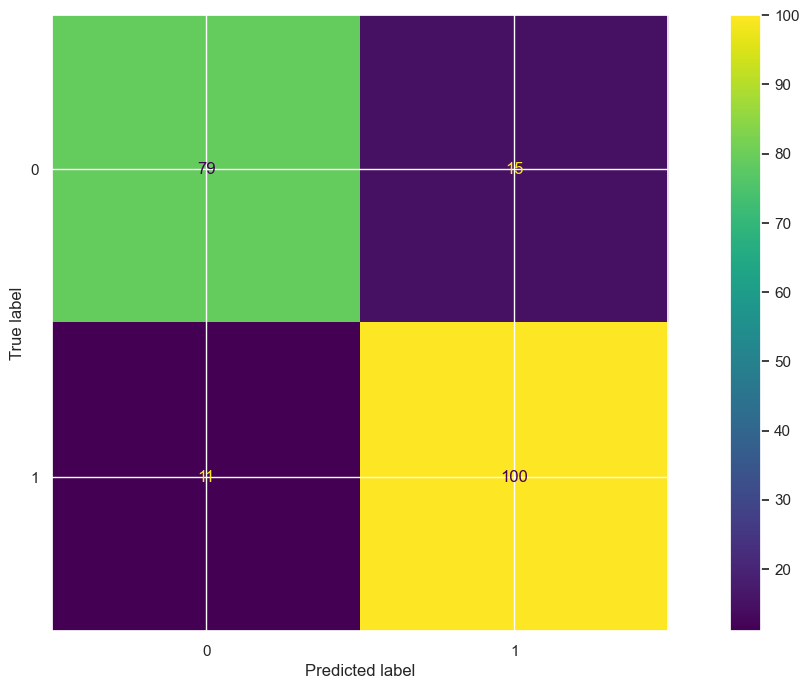

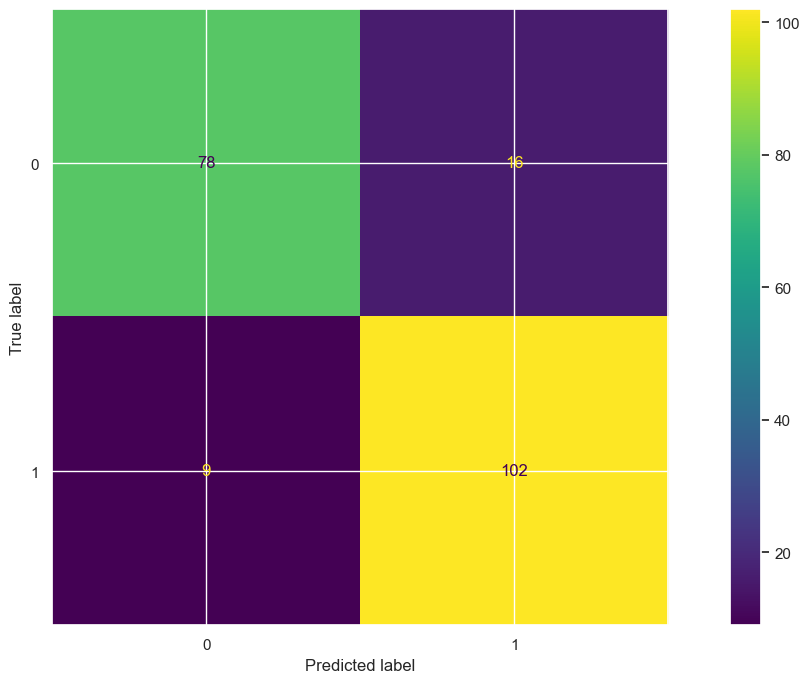

In [129]:
Y_test, predicted1 = main("model_1", optimizer=Adam())
Y_test, predicted2 = main("model_2", optimizer=RMSprop())

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Learning rate

0.0003 za malo <br>
0.0005 lepiej niz 0.001

Model: "sequential_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_198 (Dense)           (None, 64)                896       
                                                                 
 dense_199 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 0s 7ms/step - loss: 0.6839 - accuracy: 0.5997 - val_loss: 0.6316 - val_accuracy: 0.7561
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5948 - accuracy: 0.7862 - val_loss: 0.5671 - val_accuracy: 0.7805
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.5299 - accuracy: 0.8221 - val_loss: 0.5178 - val_accuracy: 0.7

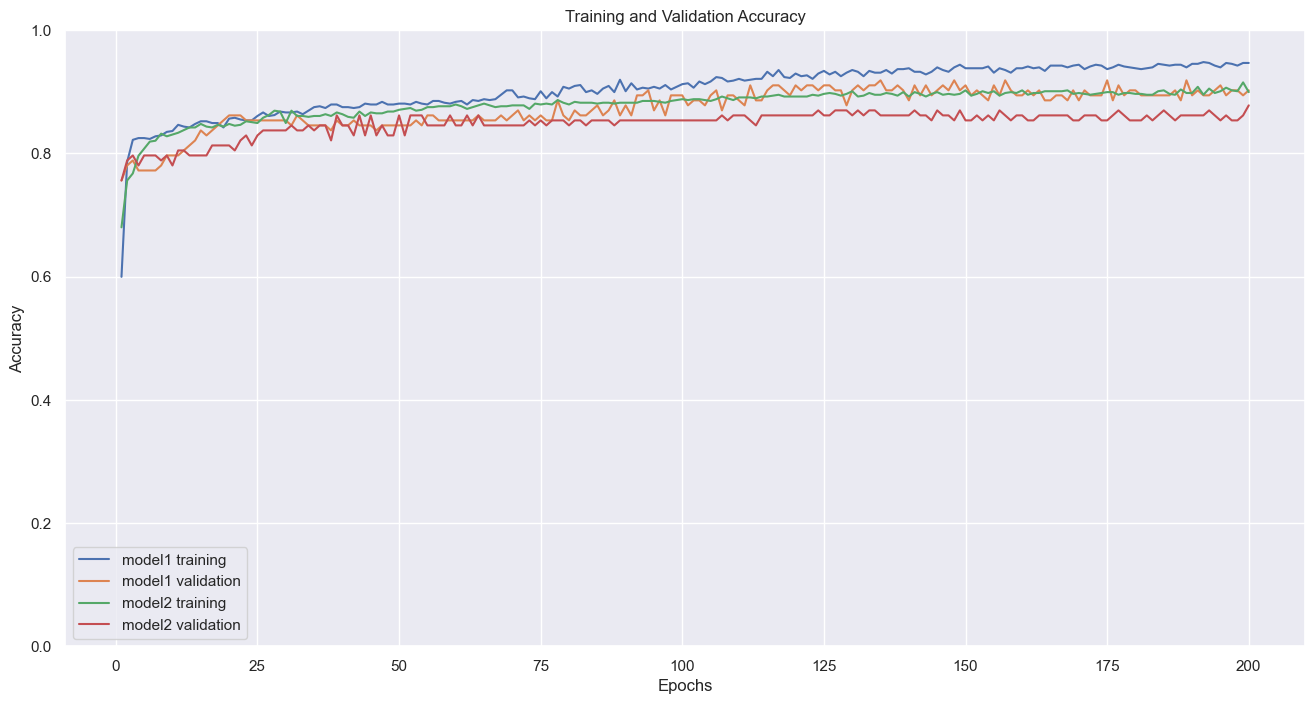

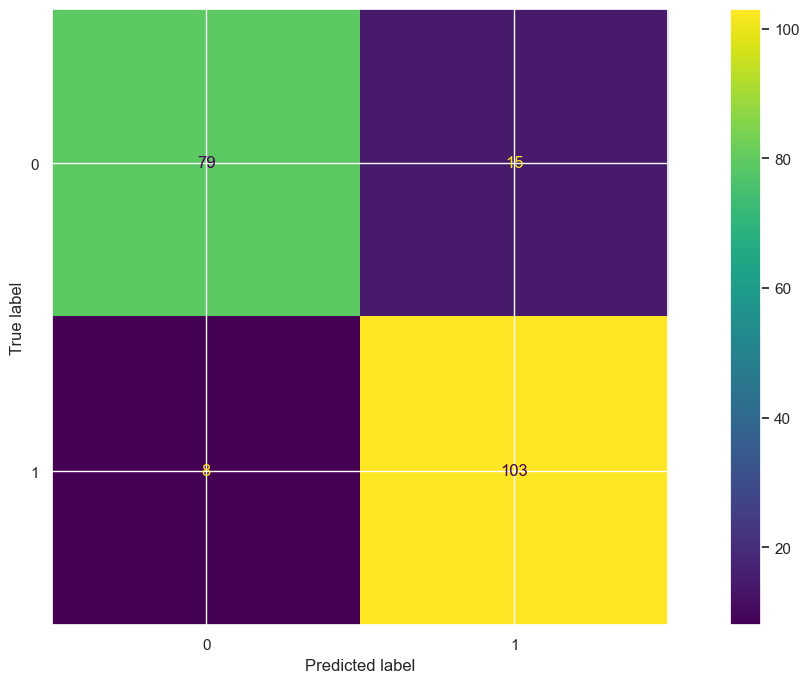

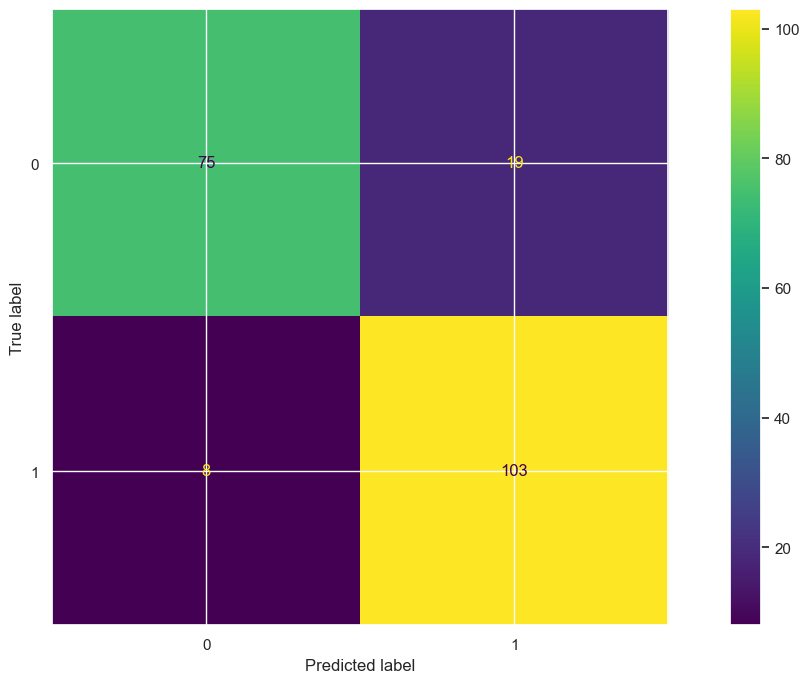

In [130]:
Y_test, predicted1 = main("model1", optimizer=Adam())  # default 0.001
Y_test, predicted2 = main("model2", optimizer=Adam(learning_rate=0.0005))

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

Model: "sequential_88"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_202 (Dense)           (None, 64)                896       
                                                                 
 dense_203 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 1s 14ms/step - loss: 0.6654 - accuracy: 0.5638 - val_loss: 0.6398 - val_accuracy: 0.6992
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.6031 - accuracy: 0.7633 - val_loss: 0.5954 - val_accuracy: 0.7398
Epoch 3/200
24/24 [==============================] - 0s 4ms/step - loss: 0.5521 - accuracy: 0.7834 - val_loss: 0.5553 - val_accuracy: 0.

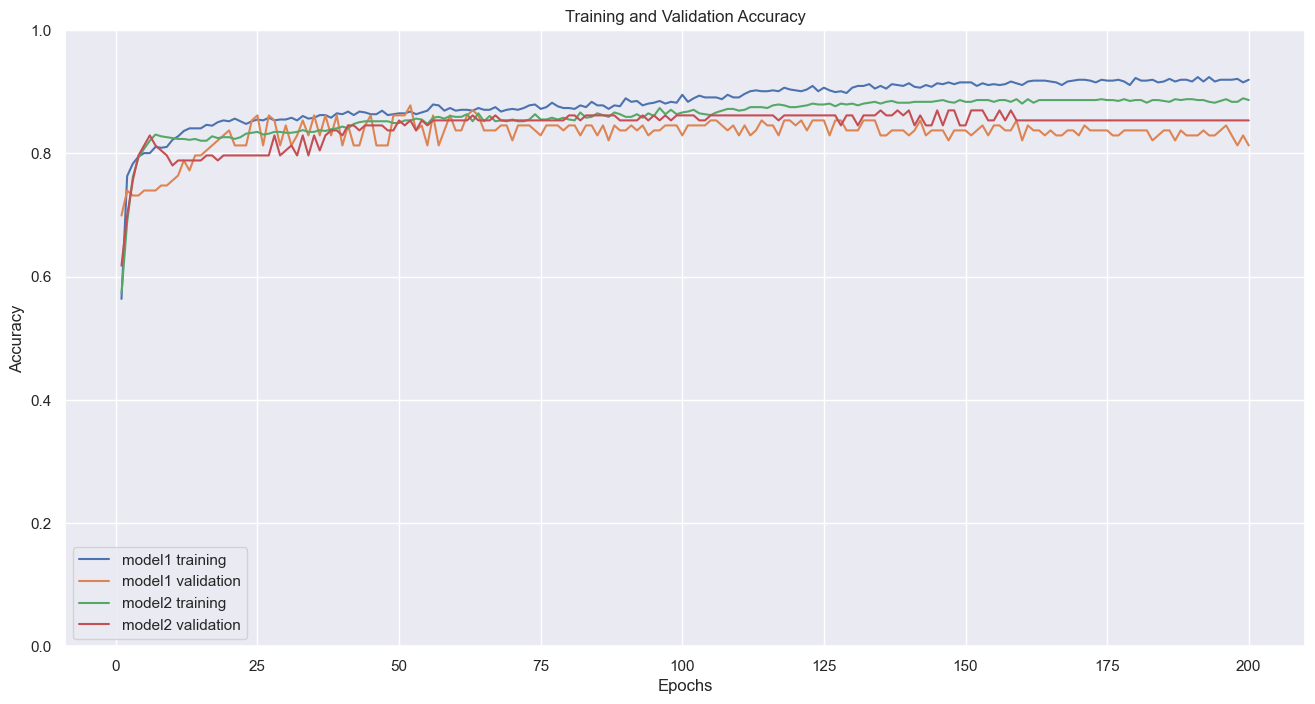

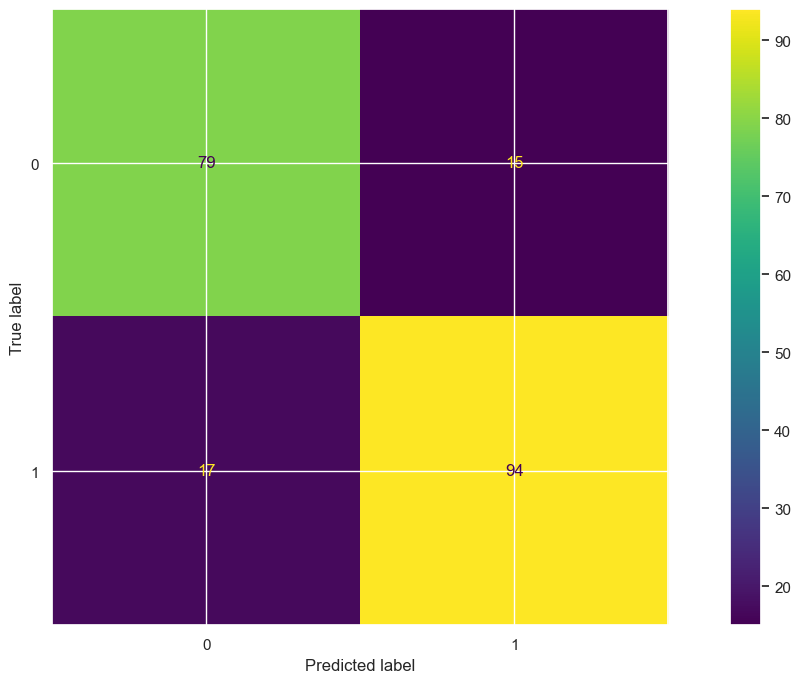

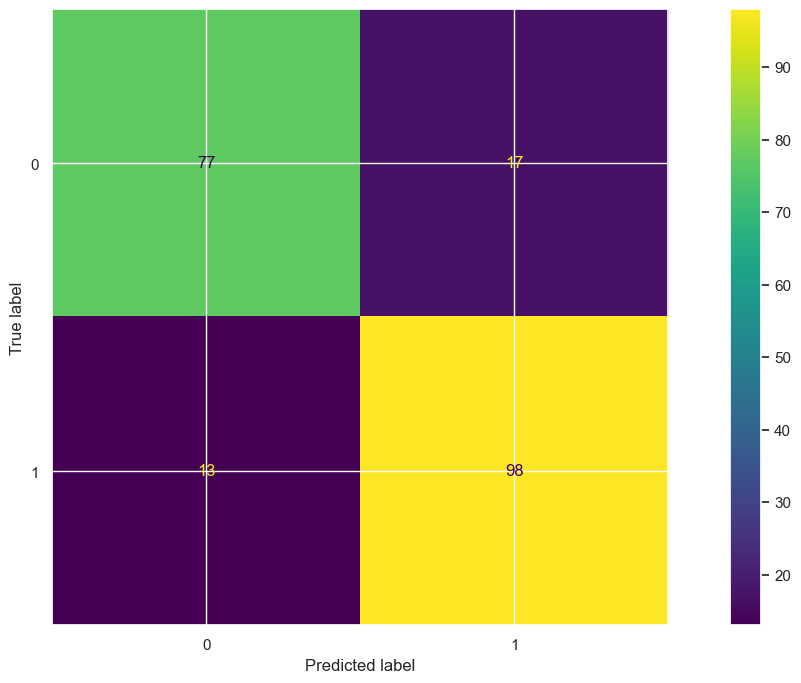

In [131]:
Y_test, predicted1 = main("model1", optimizer=RMSprop())  # default 0.001
Y_test, predicted2 = main("model2", optimizer=RMSprop(learning_rate=0.0003))

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Neurons number


* za duzo tez nie dobrze, dluzej sie liczy a wyniki podobne, moze troche bardziej stabilne
* malo neuronow na 1 warstwie - pozniej osiaga stabilnosc
* 32 optimal (?)

Model: "sequential_90"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_206 (Dense)           (None, 256)               3584      
                                                                 
 dense_207 (Dense)           (None, 128)               32896     
                                                                 
 dense_208 (Dense)           (None, 64)                8256      
                                                                 
 dense_209 (Dense)           (None, 1)                 65        
                                                                 
Total params: 44801 (175.00 KB)
Trainable params: 44801 (175.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 1s 10ms/step - loss: 0.4775 - accuracy: 0.7633 - val_loss: 0.4052 - val_accuracy: 0.8049
Epoch

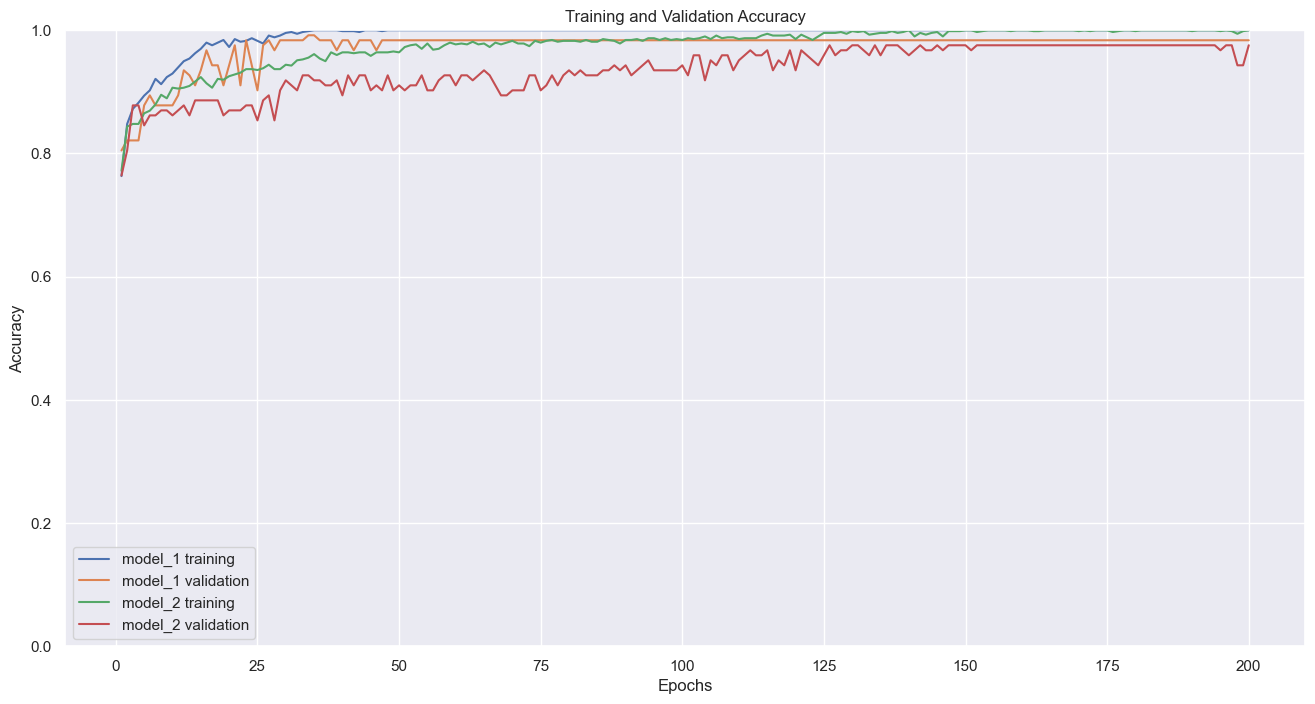

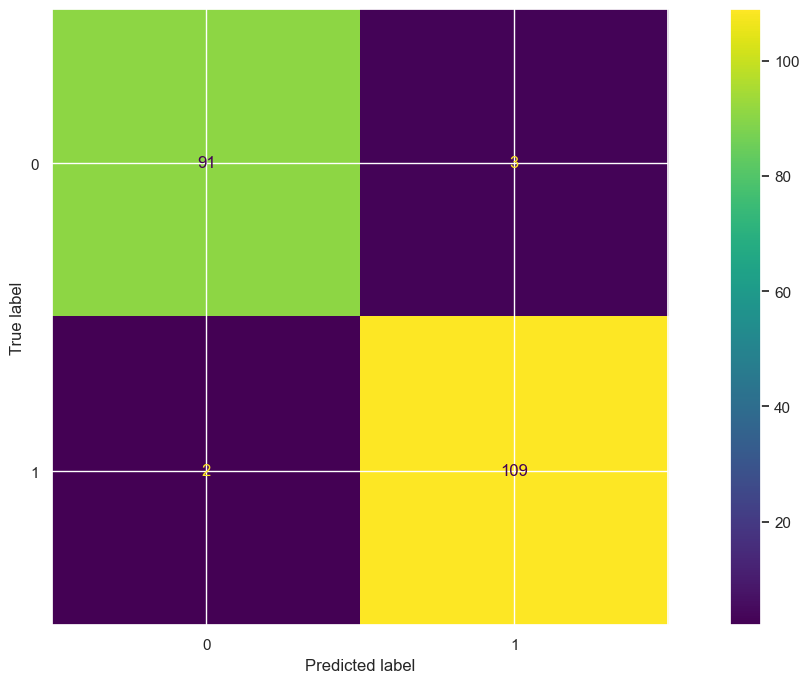

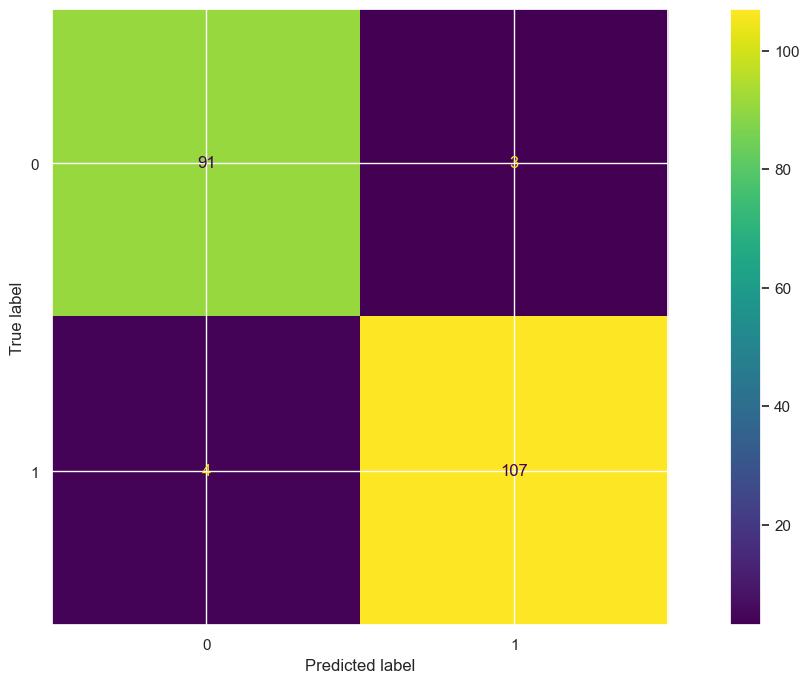

In [132]:
Y_test, predicted1 = main("model_1", neurons=[1,256,128,64], extra_layers=True) 
Y_test, predicted2 = main("model_2", neurons=[1,32,16,8], extra_layers=True)

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Activation function

Model: "sequential_92"


_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_214 (Dense)           (None, 64)                896       
                                                                 
 dense_215 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 1s 8ms/step - loss: 0.5516 - accuracy: 0.7704 - val_loss: 0.4688 - val_accuracy: 0.7398
Epoch 2/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8178 - val_loss: 0.4229 - val_accuracy: 0.7805
Epoch 3/200
24/24 [==============================] - 0s 3ms/step - loss: 0.3555 - accuracy: 0.8278 - val_loss: 0.4126 - val_accuracy: 0.8211
Epoch 4/200
24/24 [

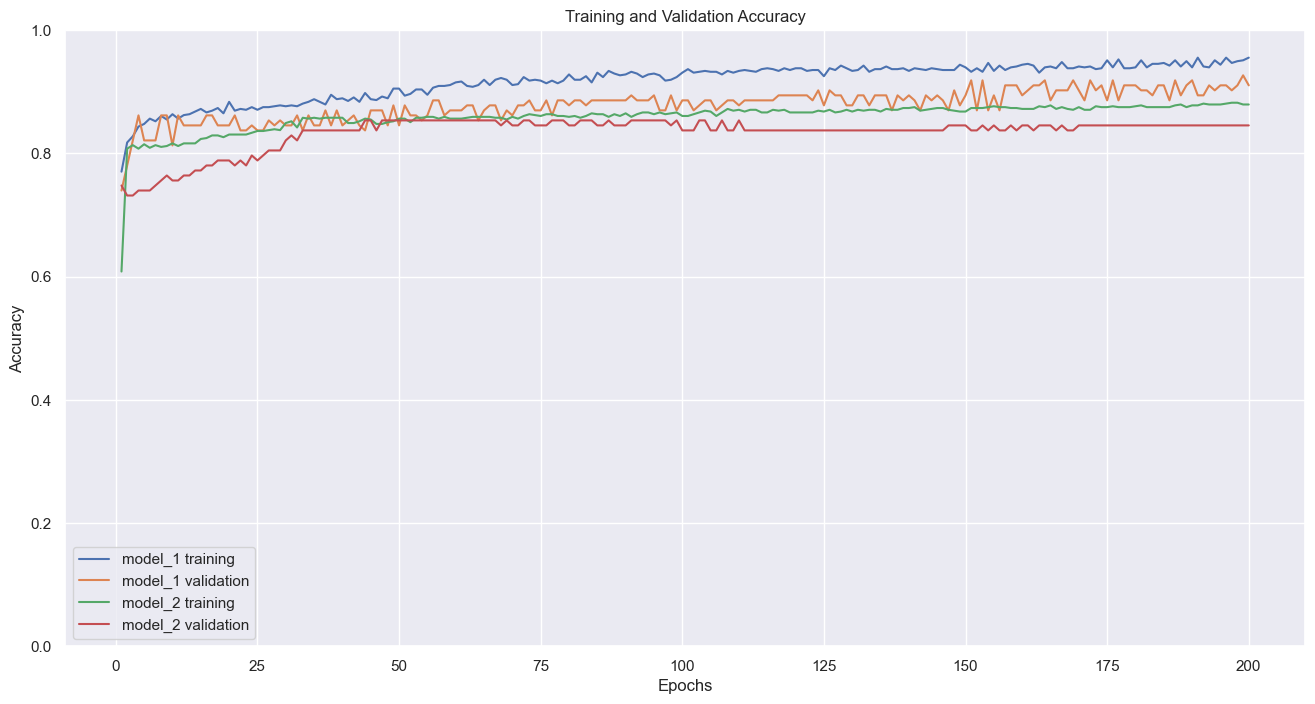

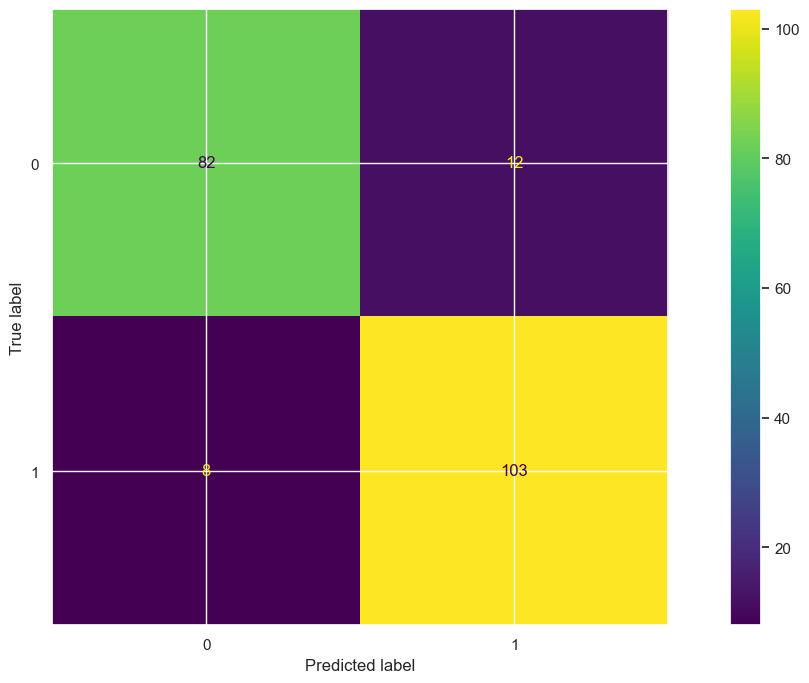

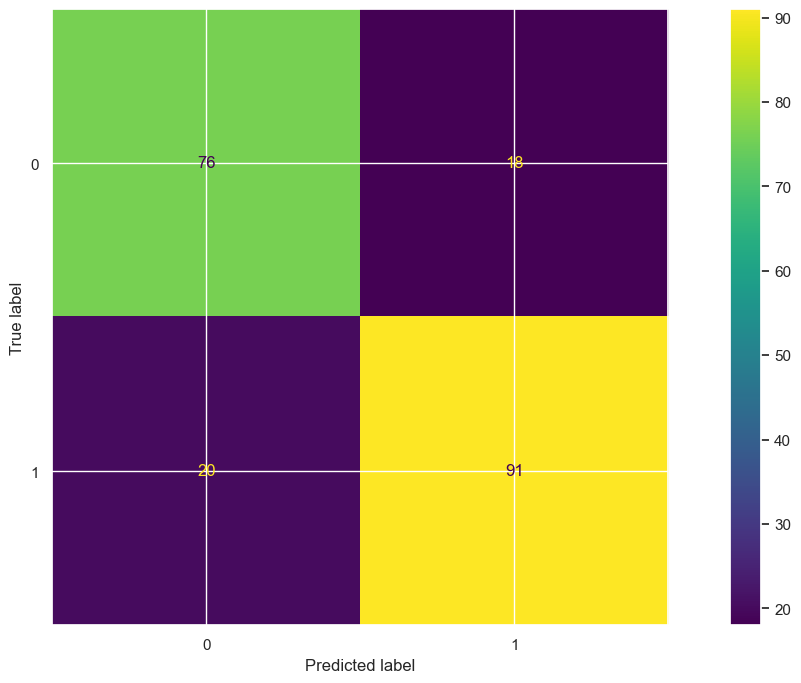

In [133]:
Y_test, predicted1 = main("model_1")
Y_test, predicted2 = main("model_2", activation_function="softmax")

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Extra layers

Model: "sequential_94"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_218 (Dense)           (None, 64)                896       
                                                                 


 dense_219 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/200
24/24 [==============================] - 1s 29ms/step - loss: 0.5799 - accuracy: 0.7217 - val_loss: 0.4806 - val_accuracy: 0.7886
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3985 - accuracy: 0.8221 - val_loss: 0.4253 - val_accuracy: 0.8049
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3592 - accuracy: 0.8336 - val_loss: 0.4119 - val_accuracy: 0.8455
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3507 - accuracy: 0.8479 - val_loss: 0.4162 - val_accuracy: 0.8618
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3424 - accuracy: 0.8623 - val_loss: 0.4035 - val_accuracy: 0.8211


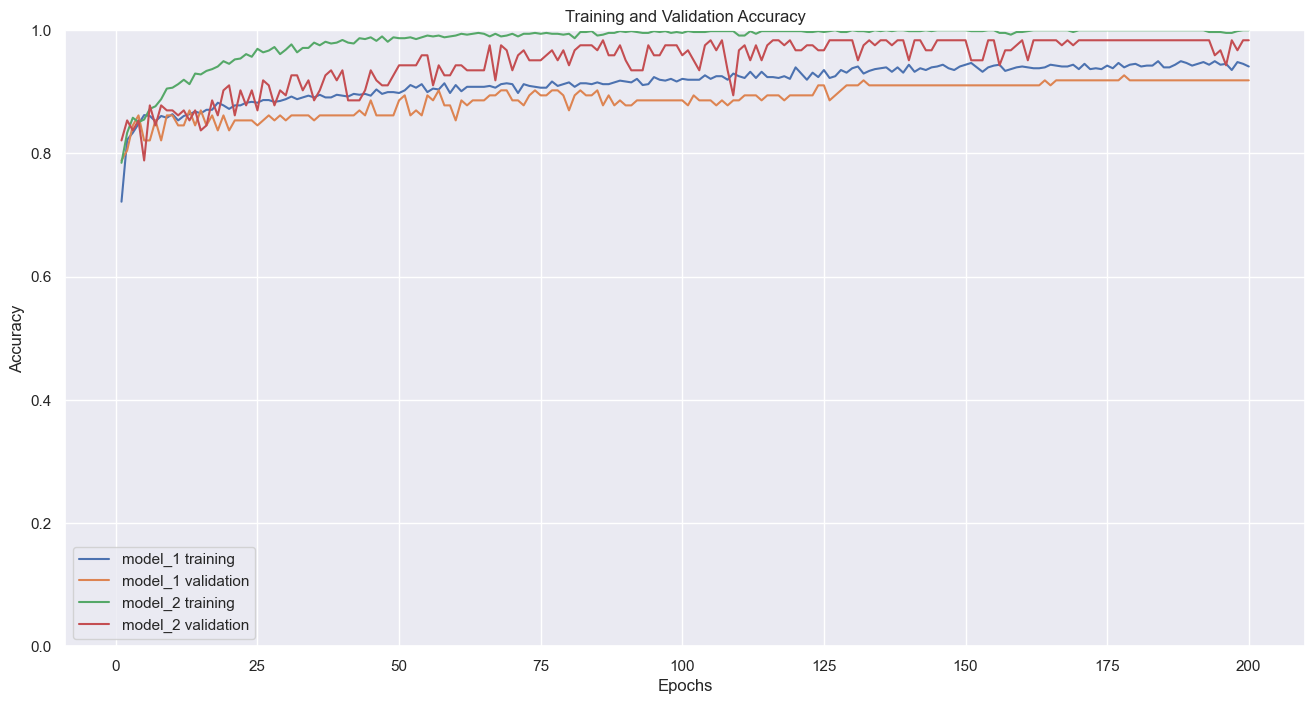

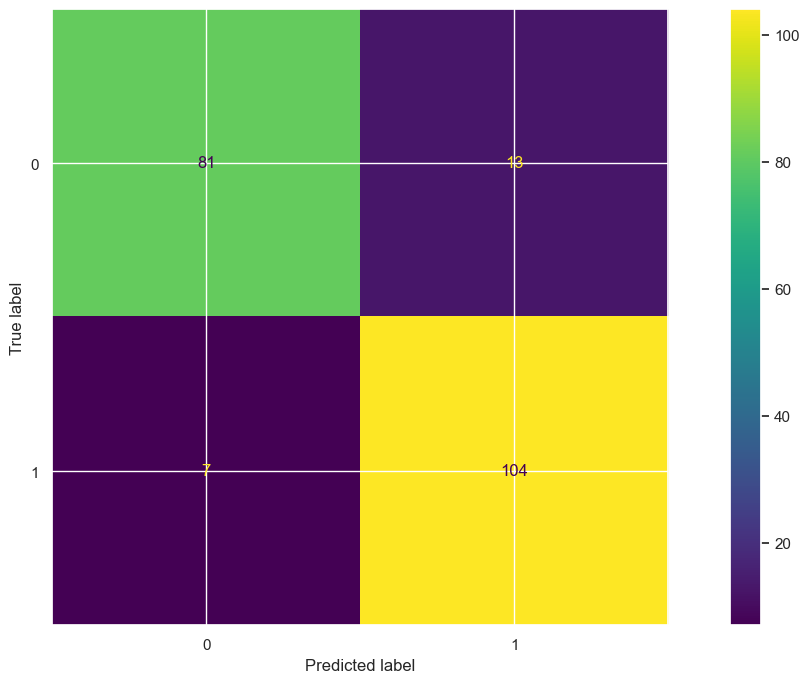

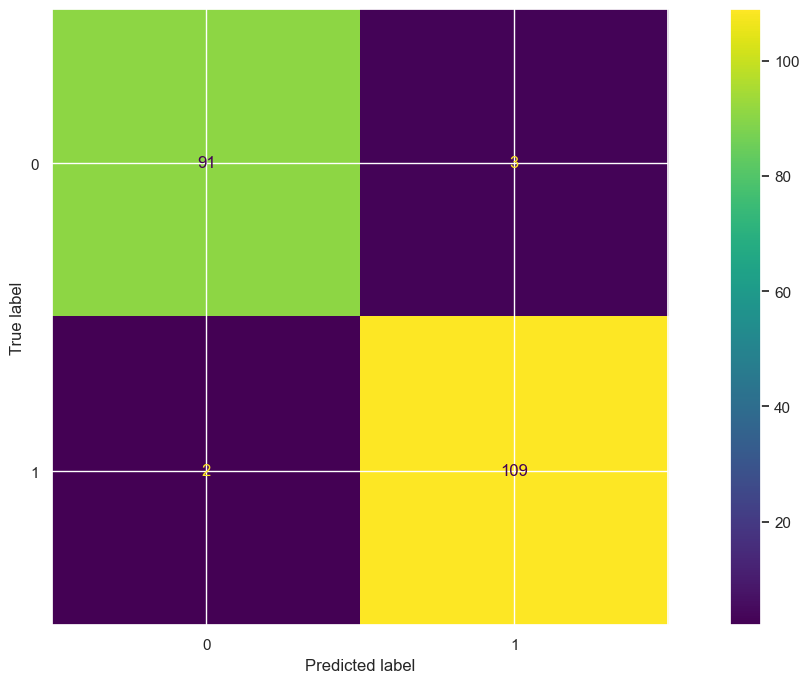

In [134]:
Y_test, predicted1 = main("model_1")
Y_test, predicted2 = main("model_2", extra_layers=True)

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Batch size

* maly batch size - dlugie obliczenia
* batch size 20 optimal (?)

Model: "sequential_96"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_224 (Dense)           (None, 64)                896       
                                                                 
 dense_225 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
24/24 [==============================] - 1s 8ms/step - loss: 0.5621 - accuracy: 0.7532 - val_loss: 0.4634 - val_accuracy: 0.8130
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3853 - accuracy: 0.8250 - val_loss: 0.4135 - val_accuracy: 0.8211
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3531 - accuracy: 0.8379 - val_loss: 0.4030 - val_accuracy: 0.8455
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3412 - accuracy: 0.8393 - val_loss: 0.4012 - val_accuracy: 0.8211
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3330 - accuracy: 0.8436 - val_loss: 0.4047 - val_accuracy: 0.8537
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3365 - accuracy: 0.8508 - val_loss: 0.3967 - val_accuracy: 0.8293
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3297 - accuracy: 0.8637 - val_loss: 0.3958 - val_accuracy: 0.8211
Epoch 8/200
2

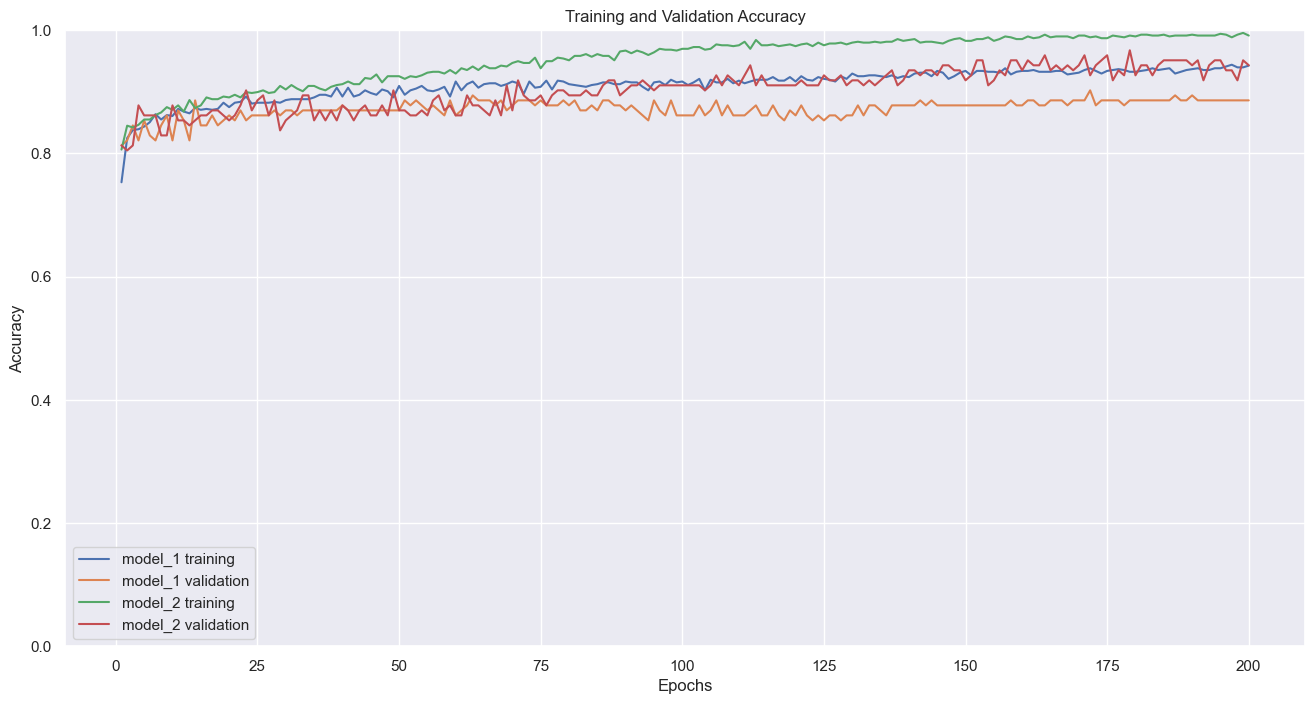

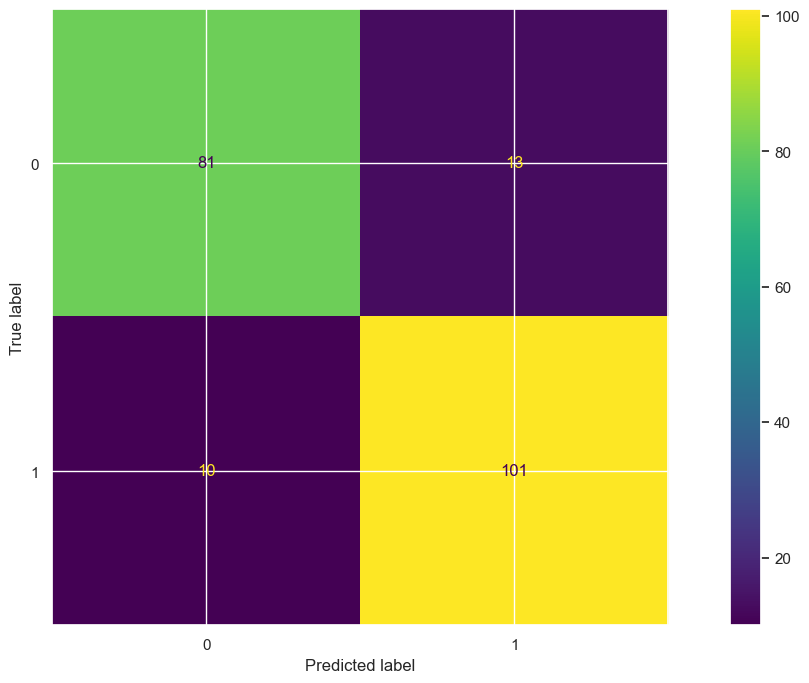

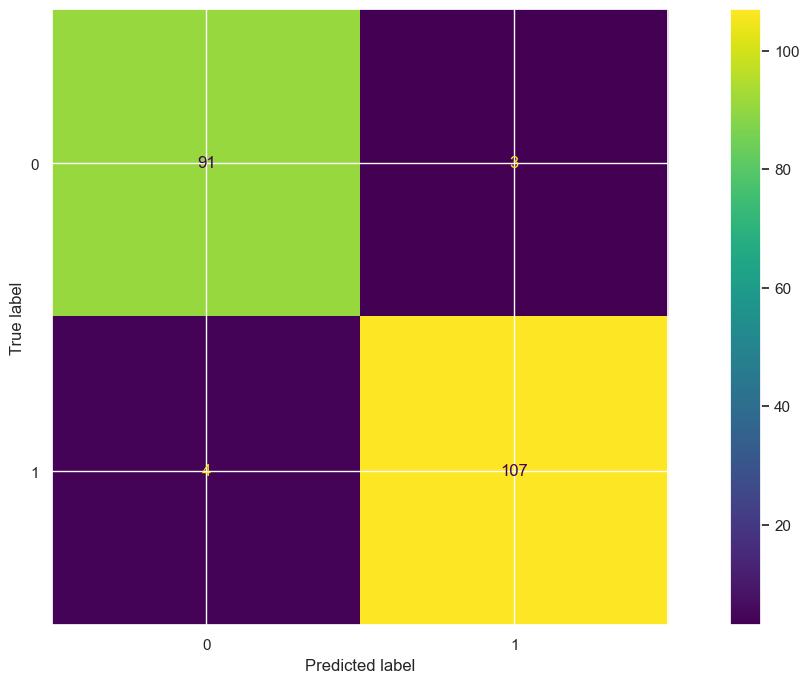

In [135]:
Y_test, predicted1 = main("model_1", batch_size=30)
Y_test, predicted2 = main("model_2", batch_size=3)

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)

## Epochs

Model: "sequential_98"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_228 (Dense)           (None, 64)                896       
                                                                 
 dense_229 (Dense)           (None, 1)                 65        
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/200
24/24 [==============================] - 0s 7ms/step - loss: 0.5377 - accuracy: 0.7848 - val_loss: 0.4519 - val_accuracy: 0.7805
Epoch 2/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3745 - accuracy: 0.8407 - val_loss: 0.4527 - val_accuracy: 0.7886
Epoch 3/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3574 - accuracy: 0.8479 - val_loss: 0.4120 - val_accuracy: 0.8374
Epoch 4/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3433 - accuracy: 0.8522 - val_loss: 0.4171 - val_accuracy: 0.8211
Epoch 5/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3408 - accuracy: 0.8580 - val_loss: 0.4071 - val_accuracy: 0.8130
Epoch 6/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3382 - accuracy: 0.8580 - val_loss: 0.4069 - val_accuracy: 0.8537
Epoch 7/200
24/24 [==============================] - 0s 2ms/step - loss: 0.3348 - accuracy: 0.8637 - val_loss: 0.4056 - val_accuracy: 0.8455
Epoch 8/200
2

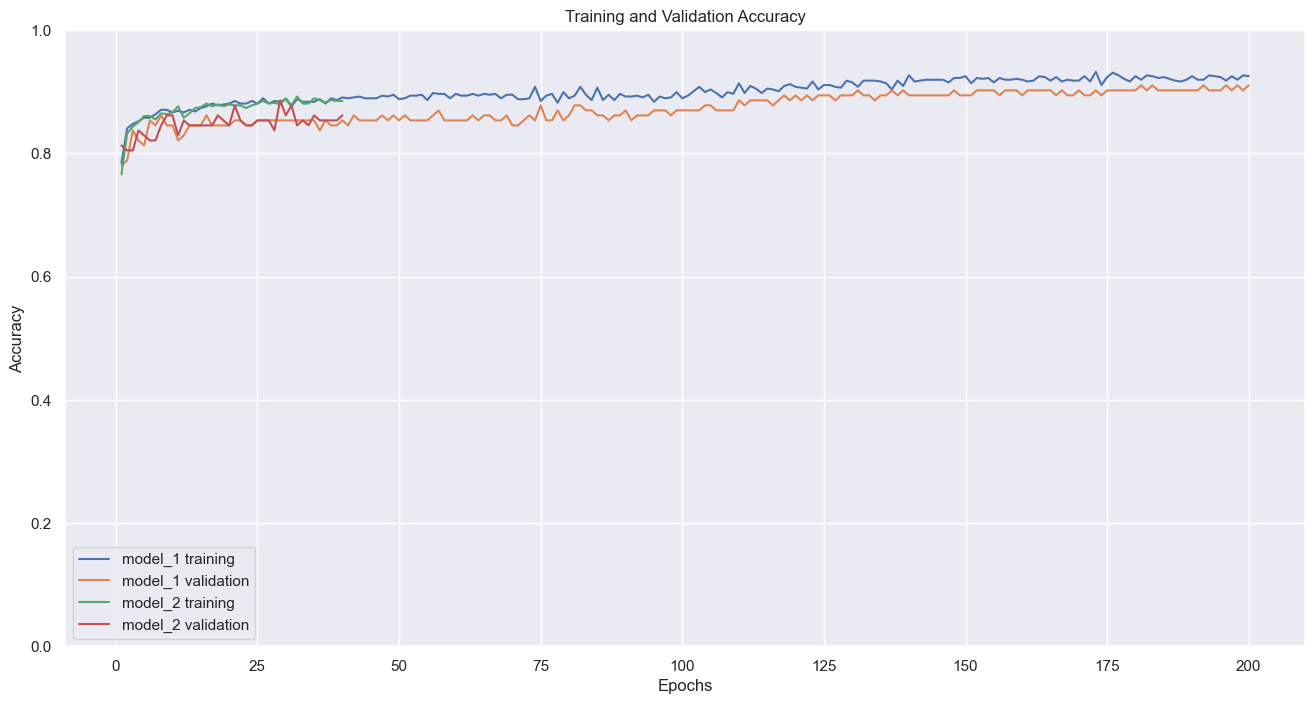

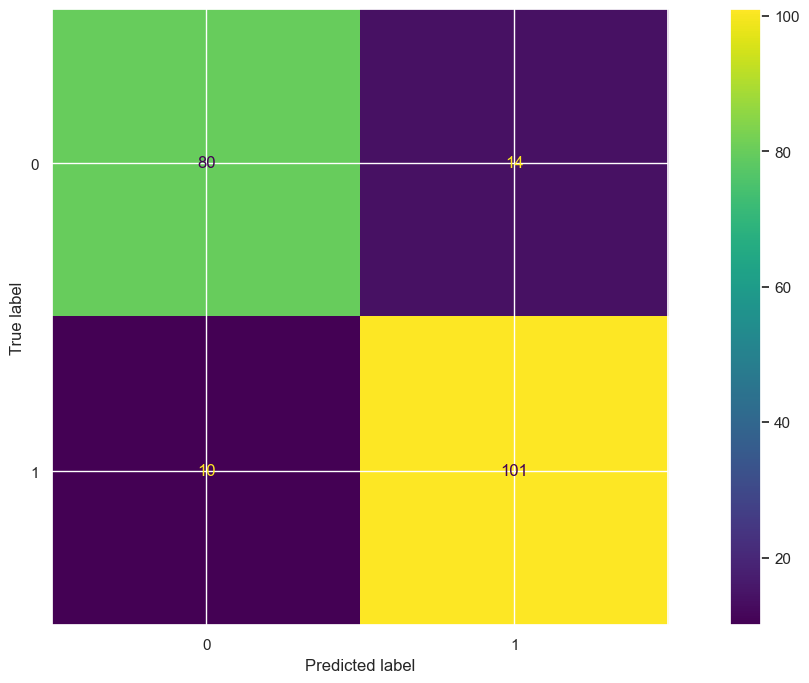

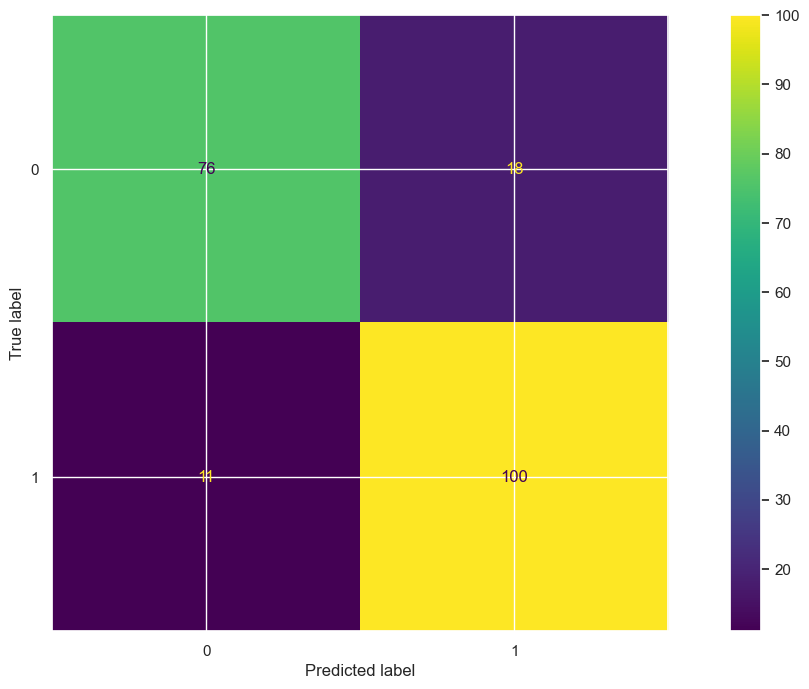

In [136]:
Y_test, predicted1 = main("model_1", epochs=200)
Y_test, predicted2 = main("model_2", epochs=40)

plot_confusion_matrix(Y_test, predicted1)
plot_confusion_matrix(Y_test, predicted2)